# Spectral Sounds: Unveiling Music Genre Classification Through Audio Spectrograms

# Introduction:
With the dominance of digital music streaming, music genre classification is an increasingly important way to develop algorithms for suggesting new songs to users. Without a way to analyze the abstract aspects of each song such as mood and tone, these algorithms must be able to make accurate predictions based only on the quantitative characteristics of the audio itself.

Hence, we aim to answer the following research question:
 **Can we predict the genre of a song based on its audio spectrograph information?** In particular, we will focus on the **classical, jazz, pop, and rock music** genres.

### Dataset Description
We will be using the Music Genre Classification dataset by Andrada on [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification). It includes observations for 1000 30-second `.wav` audio snippets, with 60 relevant variables that describe mean and variance of different aspects of its audio spectrogram (visual waveform) labeled with the corresponding genre of music. The following table goes over the information included in the data set:

| variable names                                  | units                       | description                                                                                       |
|-------------------------------------------------|-----------------------------|---------------------------------------------------------------------------------------------------|
| filename                                        |                             | name of the file.                                                                                 |
| length                                          | bytes                       | the size of the .wav file in bytes                                                                |
| chroma_stft_mean, chroma_stft_var               | normalized semitones [0, 1] | chroma feature; measures the distribution of musical pitches in the signal.                       |
| rms_mean, rms_var                               | dB                          | root mean square; measures the perceived loudness of the signal.                                  |
| spectral_centroid_mean, spectral_centroid_var   | Hz                          | measures the average frequency of the signal.                                                     |
| spectral_bandwidth_mean, spectral_bandwidth_var | Hz                          | measures the average spread of frequencies of the signal.                                         |
| rolloff_mean, rolloff_var                       | Hz                          | measures the frequency below which lies 85% of the signal.                                        |
| zero_crossing_rate_mean, zero_crossing_rate_var | crossings per byte          | measures the rate at which the signal changes its sign.                                           |
| harmony_mean, harmony_var                       | unitless [-1, 1]            | measures the “harmonic” component of the song.                                                    |
| perceptr_mean, perceptr_var                     | unitless [-1, 1]            | measures the “percussive” component of the song.                                                  |
| tempo                                           | BPM                         | measures the speed of the rhythm of the song.                                                     |
| mfcc1_mean to mfcc20_mean, mfcc1_var mfcc20_var | mel                         | frequency cepstral coefficients; measures a small set of human vocal features in the song.        |
| label                                           |                             | the category of music (blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock). |

<p style="text-align: center;">Figure 1: Data Set Information</p>

For this exploration, we will omit the harmony and perceptr values as they are not standarized measurements for audio spectrogram data. Moreover, we also ommit any mfcc values as they are generally reserved for the analysis of smaller audio subsets. 

# Methods

## Preliminary Data Processing

### Setup Environment

In [1]:
# Run this first.
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
set.seed(45)

DATASET_URL <- "https://raw.githubusercontent.com/arthu-rguo/dsci-100-proj/master/features_30_sec.csv"
GENRES <- c("classical", "jazz", "pop", "rock")
VARIABLES <- c("chroma_stft_mean", "chroma_stft_var", "rms_mean", "rms_var", "spectral_centroid_mean", "spectral_centroid_var", "spectral_bandwidth_mean", 
               "spectral_bandwidth_var", "rolloff_mean", "rolloff_var", "zero_crossing_rate_mean", "zero_crossing_rate_var")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Loading and Cleaning Data


In [12]:
# Load and tidy up the dataset.
music_data_raw <- read_csv(DATASET_URL)

music_data <- music_data_raw |>
    select(label, all_of(VARIABLES)) |>
    filter(label %in% GENRES) |>
    relocate(label) |>
    mutate(label = as_factor(label))

head(music_data)

# Split the dataset into training and testing sets.
music_split <- music_data |> 
    initial_split(props = 0.75, strata = label)

music_training_data <- training(music_split)
music_testing_data <- testing(music_split)

music_vfold <- vfold_cv(music_training_data, v = 5, strata = label)

Rows: 1000 Columns: 60
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): filename, label
dbl (58): length, chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spec...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


label,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
classical,0.2523919,0.08415318,0.03624489,0.0002207507,1505.166,44457.89,1559.006,43682.97,2716.306,299398.3,0.09822270,0.0004313938
classical,0.2149950,0.08500956,0.03062517,0.0001609684,1360.644,61611.21,1441.243,32378.73,2387.729,368797.1,0.08776563,0.0006296792
classical,0.2779581,0.08375870,0.04385955,0.0001926202,1490.275,38993.34,1600.116,31200.90,2785.294,274835.4,0.09004578,0.0003952271
classical,0.2342293,0.08345093,0.02944208,0.0003565407,1526.630,91344.31,1499.439,60196.23,2916.000,499393.9,0.10894638,0.0011608430
classical,0.2215738,0.08499950,0.04231631,0.0002093876,1705.563,68132.45,1646.064,25963.46,3174.932,333266.9,0.11285717,0.0008350001
classical,0.2685303,0.08254110,0.04326224,0.0005845473,1431.055,74049.94,1558.113,39297.27,2835.996,305081.8,0.07521004,0.0006178058


<p style="text-align: center;">Figure 2: Tidy Music Data Set</p>

## Preliminary Data Visualization


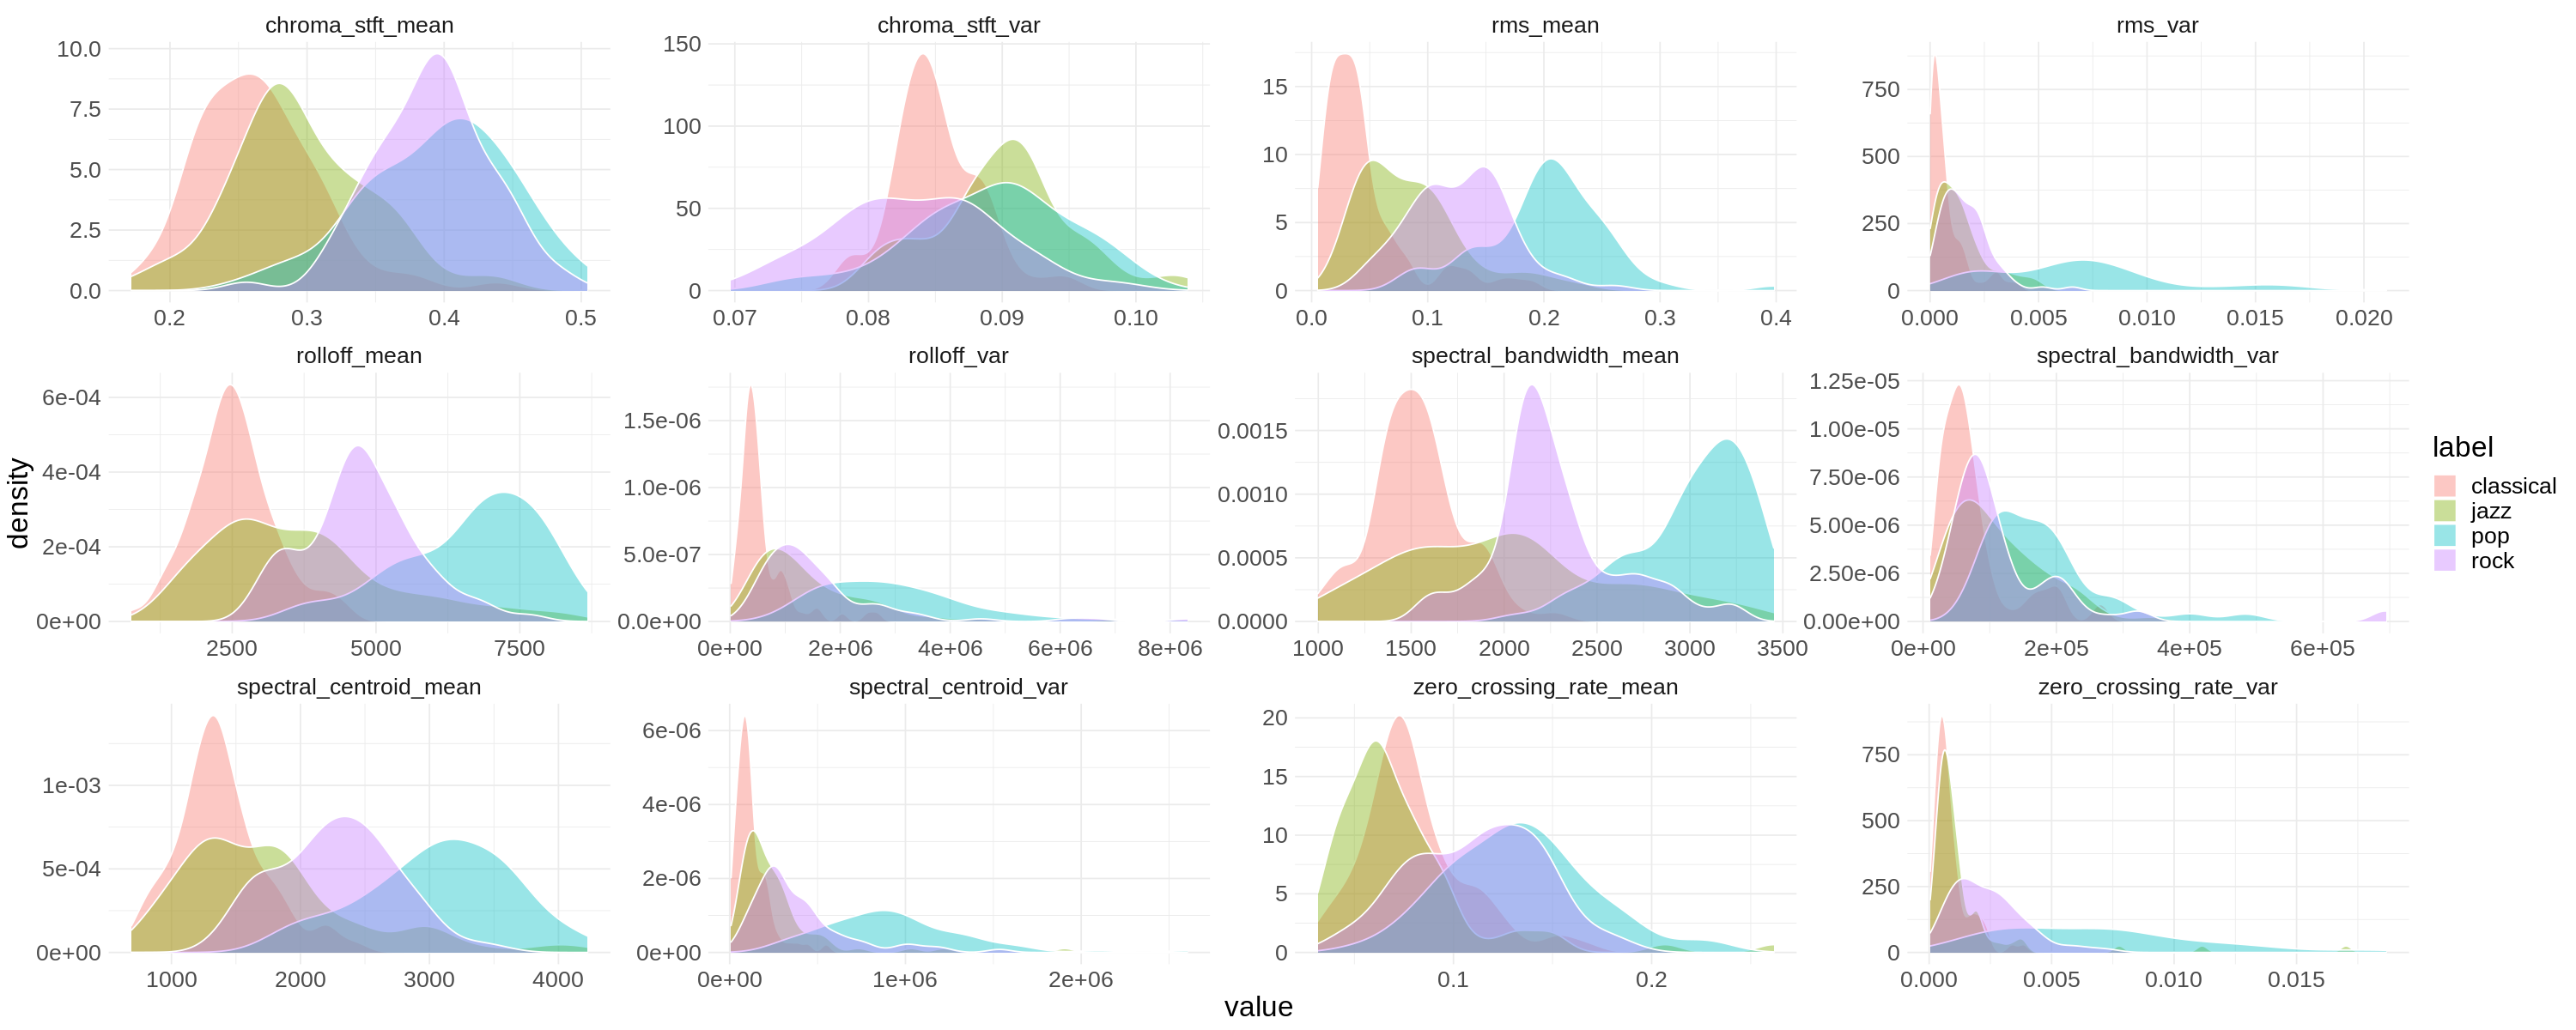

In [13]:
options(repr.plot.height = 10, repr.plot.width = 25)
music_training_data |>
    pivot_longer(cols = -label, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = label)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))


<p style="text-align: center;">Figure 3: Music Data Set Visualization</p>

## Predictor Selection

In [11]:
set.seed(4545)
#this is predictor selection
# create an empty tibble to store the results
names <- VARIABLES
kvals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    neighbors <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("label", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        music_recipe <- recipe(as.formula(model_string), 
                                data = music_training_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(music_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = music_vfold, grid = kvals) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          arrange(desc(mean)) |>
          slice(1) |>
          select(mean, neighbors)

        acc <- acc$mean |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

best_params <- accuracies |>
    arrange(desc(accuracy)) 

best_params

size,model_string,accuracy
<int>,<chr>,<dbl>
6,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var,0.8300000
7,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var+spectral_centroid_var,0.8166667
5,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var,0.8133333
8,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var+spectral_centroid_var+rolloff_var,0.8133333
9,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var+spectral_centroid_var+rolloff_var+chroma_stft_var,0.8100000
10,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var+spectral_centroid_var+rolloff_var+chroma_stft_var+rolloff_mean,0.8100000
11,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var+spectral_centroid_var+rolloff_var+chroma_stft_var+rolloff_mean+spectral_centroid_mean,0.8100000
4,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean,0.8066667
12,label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var+spectral_centroid_var+rolloff_var+chroma_stft_var+rolloff_mean+spectral_centroid_mean+spectral_bandwidth_var,0.7933333


<p style="text-align: center;">Figure 4: Forward Selection Results</p>

## $K$-value Selection

In [14]:
set.seed(4545)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_mode("classification") |>
    set_engine("kknn")

knn_recipe <- recipe(label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var, 
                     data = music_training_data) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

music_fit_tune <- workflow() |> 
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = music_vfold, grid = tibble(neighbors = seq(from = 1, to = 50, by = 1))) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
    
head(music_fit_tune)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8166667,5,0.017480147,Preprocessor1_Model01
2,accuracy,multiclass,0.8166667,5,0.017480147,Preprocessor1_Model02
3,accuracy,multiclass,0.8166667,5,0.015811388,Preprocessor1_Model03
5,accuracy,multiclass,0.8133333,5,0.014337209,Preprocessor1_Model05
6,accuracy,multiclass,0.8133333,5,0.009718253,Preprocessor1_Model06
8,accuracy,multiclass,0.8133333,5,0.016996732,Preprocessor1_Model08


<b><p style="text-align: left;">Figure 5.1: K Value Accuracies Table</p><b>

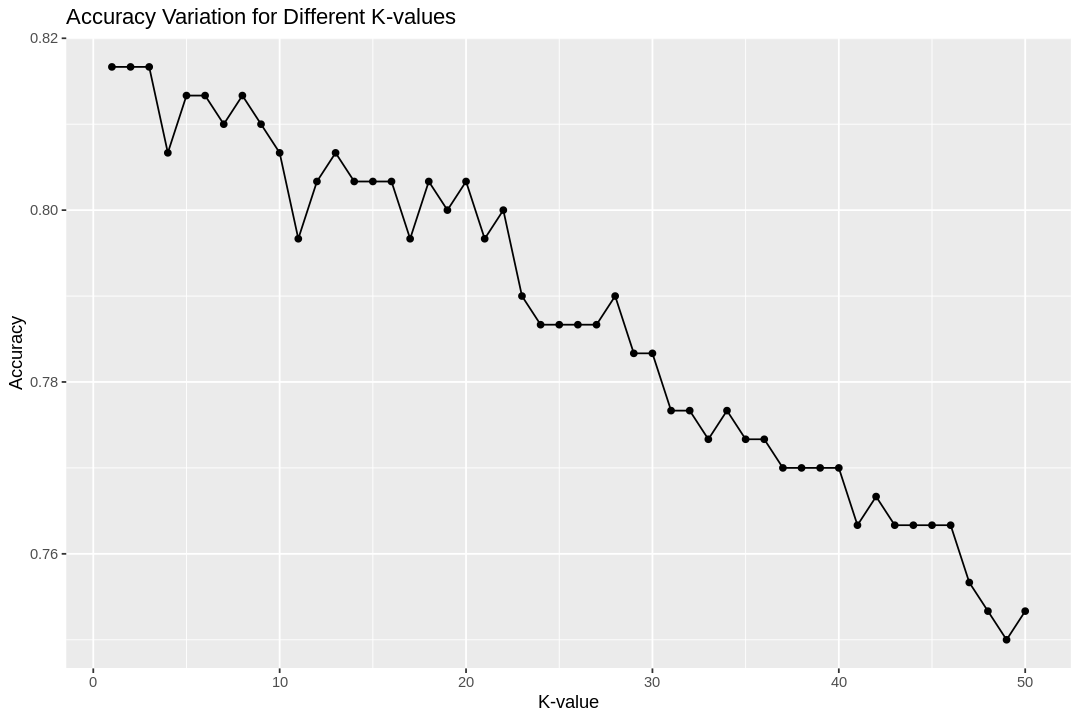

In [15]:
options(repr.plot.height = 6, repr.plot.width = 9)
music_fit_tune |> ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    labs(x = "K-value", y = "Accuracy", title = "Accuracy Variation for Different K-values")

<b><p style="text-align: left;">Figure 5.2: K Value vs Accuracy Graph</p><b>

Given the following graph, we decided to choose neighbors to be equal to 3 as it has a good balance between accuracy, as well as consistency for our estimates.  

In [25]:
tuned_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |> set_engine("kknn") |> set_mode("classification")

tuned_workflow <- workflow() |> add_recipe(knn_recipe) |> add_model(tuned_knn) |> fit(data = music_training_data)



In [31]:
music_preds <- tuned_workflow |> predict(music_testing_data) |> bind_cols(music_testing_data)
music_confusion_matrix <- music_preds |> conf_mat(truth = label, estimate = .pred_class)
music_metrics <- music_preds |> metrics(truth = label, estimate = .pred_class) |> filter(.metric == "accuracy")
music_metrics 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.77


<p style="text-align: left;"> <b>Figure 6: <b> Music Prediction Accuracy</p>

In [32]:
music_confusion_matrix

           Truth
Prediction  classical jazz pop rock
  classical        23    6   0    0
  jazz              1   13   0    2
  pop               0    0  20    2
  rock              1    6   5   21

<b><p style="text-align: left;">Figure 7: Music Predictions Confusion Matrix</p> <b>

# Model Discussion

Based on our testing data, the K-Nearest-Neighbours model correctly predicts the category of music based off its spectrograph information approximately 77% of the time. For a data set with 4 categories of classification, this is significantly better than a random guess, and yields credence towards the hypothesis that we can in fact predict the genre of music based on its spectrograph information. 

Taking a look at the confusion matrix, we see that the model had a difficult time predicting Jazz, often times mistaking it for classical and rock. Perhaps this is unsurprising as Jazz is known for its formless nature, and often has less of a distinct structure compared to the other genres, making it difficult even for a machine to classify. Originally, we sought to gain a deeper understanding of the distinguishing informative and discriminative characteristics of music genres, and the larger relative misclassification of Jazz implies that it's lack of these informative and discriminative features make it difficult to classify. 

In a similar study conducted by Agrawal on the same data set using KNN with 5 neighbors, their model had a testing accuracy of 70.67%. In the study, they performed the classification on all the available predictors, while in this study, predictor selection was employed to optimize the predictors used. The increase in model accuracy by 7% is a significant increase over the other study, and suggests that the methodology is valid. 


# Potential Impacts
Overall, the findings can have practical implications in the music industry such as streaming services that can train recommendation models on a user's music taste and deliver musical recommendations curated to their tastes, enhacing music discovery and user experience. In addition, these findings can help improve musical analysis, and assist music production processes by automating 

### Future Questions
- How does the performance of KNN classification compare to other algorithms for genre classification?

Various other studies such as one conducted by Ceylan use convolutional neural networks to make their classifications, achieving testing accuracies from 82.1% to 92.0%. Given the simplistic nature of our KNN model, it is surprising to see that its results were competitive even against convolutional neural networks which are much more computationally expensive and 

- How can genre classification models handle songs that contain elements of multiple genres or blur genre boundaries?

- If 
- Given that it is possible for a machine to classify genre based on its spectrograph information, could an AI generate sounds that matches the characteristics of a genre to create  music?



Ceylan, H. C., Hardalaç, N., Kara, A. C., &amp; Hardalaç, F. (2021). Automatic Music Genre Classification and Its Relation with Music Education. World Journal of Education, 11(2). https://doi.org/10.5430/wje.v11n2p36 

Agrawal, R. (2022, April 6). Music Genre Classification Project Using Machine Learning Techniques. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2022/03/music-genre-classification-project-using-machine-learning-techniques/ 